<a href="https://colab.research.google.com/github/rish4/CNN-on-KID-new/blob/master/CNN_on_KID_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
## Set file paths to image files
#project_path = "/Users/hellojenny/Metis/Metis-Bootcamp/Projects/Project 5 - Image Prediction using CNN"
train_path = "/content/drive/My Drive/KID dataset - Copy/Training set"
#val_path = project_path + "/chest_xray/val/"
test_path = "/content/drive/My Drive/KID dataset - Copy/Test set"

## Set up hyperparameters that will be used later
hyper_dimension = 64
hyper_batch_size = 32
hyper_epochs = 100
hyper_channels = 3
hyper_mode = 'rgb'

## Generate batches of image data (train, validation, and test) with data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
#val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary', 
                                                    seed = 42)
'''val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)'''
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Found 685 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


In [6]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=9, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=9, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=9, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.summary()

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 80, 
                              validation_data = test_generator,
                              validation_steps = len(test_generator), 
                              verbose=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 56, 56, 32)        7808      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 32)        82976     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 32)          82976     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

In [7]:
def create_charts(cnn, cnn_model):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Abnormal']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    ;
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

[Summary Statistics]
Accuracy = 88.30% | Precision = 89.61% | Recall = 85.19% | Specificity = 91.11% | F1 Score = 87.34%


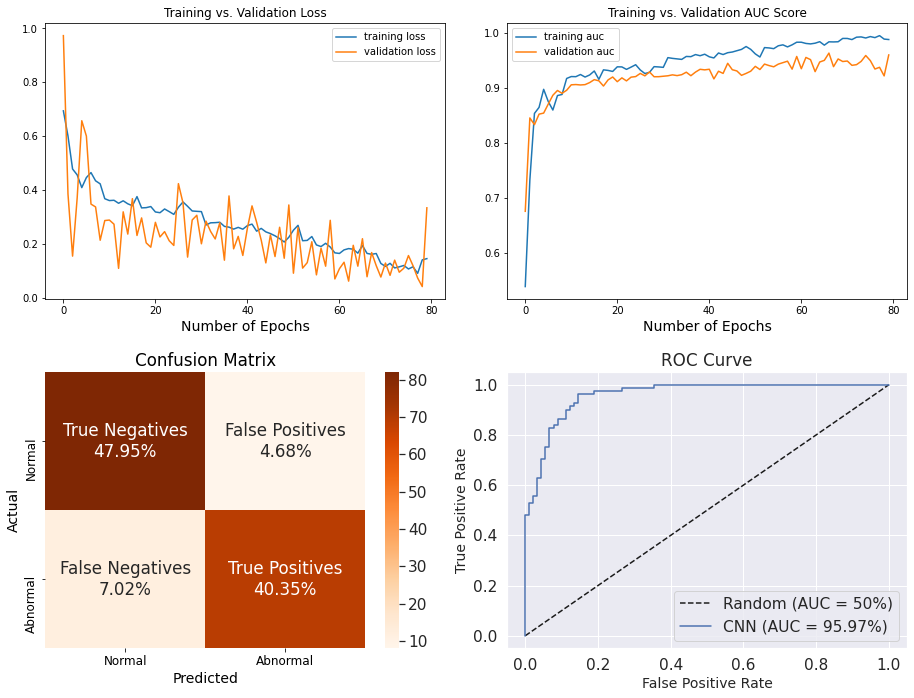

In [8]:
create_charts(cnn, cnn_model)